# CSI 5140 Assignment 3

## Samantha Bracellari

In this assignment you will train a convolution neural network to perform image classification using Fashion-MNIST dataset.

The dataset has 10 classes; you will use only 5 classes of your choice. The training set for each class has 60000 images and there are 10000 images for testing for each class. You will use the following configuration for your CNN:

<div style='display: flex; justify-content: center;'>
  <img src='img/cnn.png' style='height: 400px; width: auto;'>
</div>


The following tasks are expected from this assignment:

1. Tabulate the performance on train/test data in the form of a 5 $\times$ 5 confusion matrix.
2. Extract the weights of the filters in both of the convolution layers after training and visualize them as gray level images. Comment on filter shapes.
3. Retrain the network with a different mask size, e.g., 3 $\times$ 3 or 3 $\times$ 5 or 5 $\times$ 7 and tabulate the performance in the form of a confusion matrix.
4. Select a subset of 100 test images. Measure the accuracy on the subset using any of the trained models from steps 1-3 above. Next, flip the test images at random either horizontally or vertically and measure the accuracy again. Comment on the results.
5. Go back to Fashion-MNIST dataset and pick 100 test examples from each of the **five remaining classes not used in your experiment so far**. Feed these test examples to your trained network and determine the accuracy/confusion matrix. How does this accuracy compare with the accuracy obtained in Step 1? Is there a way to improve the accuracy obtained in Step 5?

### Part 1 — Original Model Performance

This section will set the basis for the rest of the assignment. I will often reference it in further sections if the code has not changed.

First, we begin by loading the data, normalizing it, and extracting 5 classes as well as defining our DataLoaders.

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

transform = transforms.Compose([
    transforms.ToTensor(),             # load data as pytorch tensors
    transforms.Normalize((0.5), (0.5)) # normalize/scale the images
])

# download the data from MNIST & transform it
train_data = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
test_data  = datasets.FashionMNIST('data', train=False, download=True, transform=transform)

# for this first part, we train & test with even-numbered labels
# i.e., 0, 2, 4, 6, 8
# we create masks that include only indices of those even-numbered labels
train_mask = [i for i in range(len(train_data)) if train_data[i][1] % 2 == 0]
test_mask  = [i for i in range(len(test_data)) if test_data[i][1] % 2 == 0]

# use pytorch's subset function and the above masks to separate out 
# the desired data 
trainset = Subset(train_data, train_mask)
testset  = Subset(test_data, test_mask)

# re-map the labels. the net will only be expected labels of 0-4
    # 0 -> 0
    # 2 -> 1
    # 4 -> 2
    # 6 -> 3
    # 8 -> 4
trainset = [[t[0], int(t[1]/2)] for t in trainset]
testset  = [[t[0], int(t[1]/2)] for t in testset]

# wrap the data in a pytorch dataloader object
trainloader = DataLoader(trainset, batch_size=1, shuffle=True)
testloader  = DataLoader(testset, batch_size=1, shuffle=True)

Next, we'll visualize a few of the images in the training set.

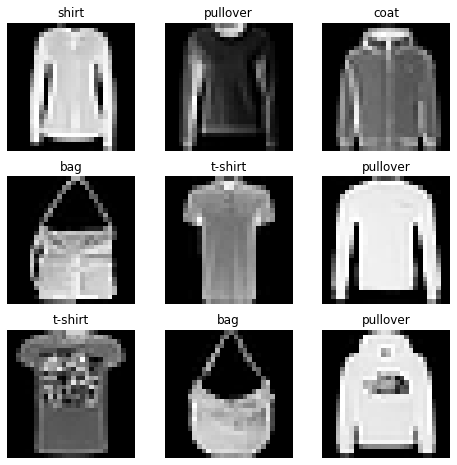

In [4]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt 
import numpy as np 

classes = ['t-shirt', 'pullover', 'coat', 'shirt', 'bag']

def imshow(img):
    img = img / 2 + 0.5 # un-normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

figure = plt.figure(figsize=(8, 8))
for i in range(1, 10):
    figure.add_subplot(3, 3, i)
    image, label = next(iter(trainloader))
    plt.title(classes[label[0].item()])
    plt.axis("off")
    img = image[0].squeeze()
    label = label[0]
    imshow(make_grid(img))
plt.show()

Now we'll define our neural net, as well as our loss criteria and optimizer function.

In [5]:
import torch.nn as nn 
import torch.nn.functional as F 
from torch import optim 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Now, we train the model, and take a look and the loss every 10,000 iterations.

In [6]:
from torch.autograd import Variable

for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data 
        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10000 == 9999:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/10000))
            running_loss = 0.0
print('finished training')

[1, 10000] loss: 0.840
[1, 20000] loss: 0.592
[1, 30000] loss: 0.530
[2, 10000] loss: 0.481
[2, 20000] loss: 0.465
[2, 30000] loss: 0.443
finished training


Let's look at some of the predictions our model made on the test data.

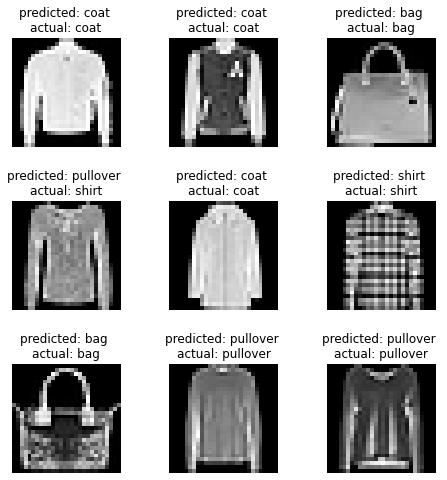

In [7]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch

figure = plt.figure(figsize=(8, 8))
plt.subplots_adjust(hspace=0.5)
for i in range(1, 10):
    figure.add_subplot(3, 3, i)
    images, labels = next(iter(testloader))
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    plt.title('predicted: %s \nactual: %s' % (classes[predicted.item()], classes[labels[0].item()]))
    plt.axis("off")
    img = images[0].squeeze()
    label = labels[0]
    imshow(make_grid(img))
plt.show()

The model performed decently well from what we can see in this small subset of images. It seemed to struggle between "shirt" and "t-shirt", which makes sense as those categories are pretty similar.

Now, we look at the overall accuracy of the model, as well as categorical accuracy.

In [8]:
import torch 
from torch.autograd import Variable

correct, total =  0, 0
labels, predictions = [], []
for data in testloader:
    image, label = data
    output = net(Variable(image))
    _, prediction = torch.max(output.data, 1)

    predictions.append(prediction.item())
    labels.append(label.item())
    total += label.size(0)
    correct += (prediction == label).sum()

score = 100*(correct.item()/total)
print('accuracy on 10000 test images: %2d%%' % score)

class_correct = list(0. for _ in range(5))
class_total = list(0. for _ in range(5))
for data in testloader:
    image, label = data 
    output = net(Variable(image))
    _, prediction = torch.max(output.data, 1)
    c = (prediction == label).squeeze()

    class_correct[label] += c
    class_total[label] += 1

for i in range(5):
    print('accuracy of %5s:\t%2d%%' % (
        classes[i], 100*class_correct[i]/class_total[i]
    ))

accuracy on 10000 test images: 82%
accuracy of t-shirt:	88%
accuracy of pullover:	81%
accuracy of  coat:	81%
accuracy of shirt:	63%
accuracy of   bag:	98%


As we can see, the accuracy of "t-shirt" and "shirt" are lower than the other categories.

Finally, we tabulate our data in the form of a confusion matrix.

Text(0.5, 1.0, 'accuracy score: 82%')

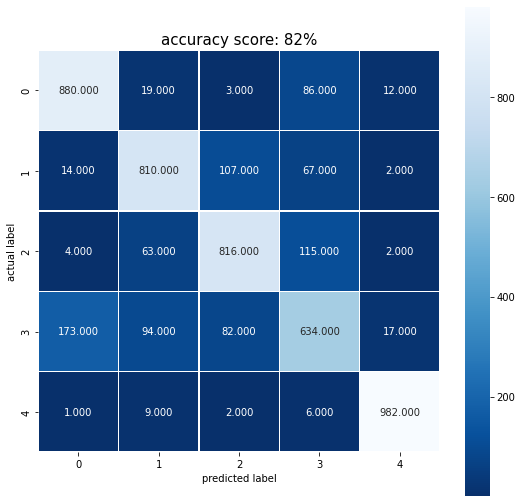

In [9]:
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt 

title = 'accuracy score: {:.0%}'.format(correct/total)
cm = metrics.confusion_matrix(labels, predictions)

plt.figure(figsize=(9,9))
sns.heatmap(
    cm, annot=True, fmt='0.3f', linewidths=0.5, square=True, cmap='Blues_r'
)
plt.ylabel('actual label')
plt.xlabel('predicted label')
plt.title(title, size=15)

The confusion matrix supports our accuracy calculations well, with the highest scores along the diagonal where the predicted label is equal to the target label.

-----

### Part 2 – Convolution Visualization

In this section, we visualize the weights of each convolution layer as grey scale images.

We first define a short function to un-normalize the image and transpose it before plotting.

In [10]:
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 # un-normalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

The first layer has one set of weights, with 6 images in that set.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


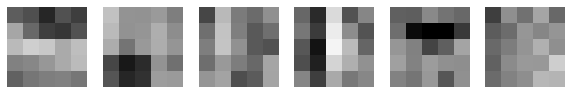

In [11]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

conv1 = net.conv1.weight

fig1, axs1 = plt.subplots(nrows=1, ncols=6, figsize=(10, 10))
for i in range(len(conv1)):
    img = imshow(make_grid(conv1[i]))
    axs1[i].axis("off")
    axs1[i].imshow(img)

The second layer has 16 sets of 6 images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


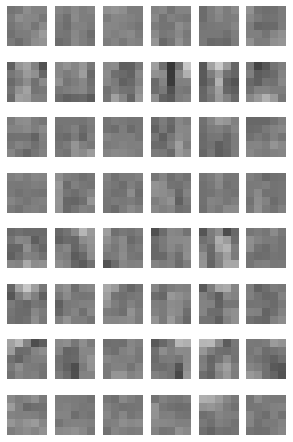

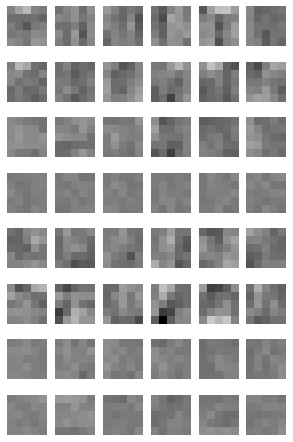

In [24]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

conv2 = net.conv2.weight

fig2, axs2 = plt.subplots(nrows=8, ncols=6, figsize=(5, 8))
for i in range(8):
    for j in range(len(conv2[i])):
        img = imshow(make_grid(conv2[i][j]))
        axs2[i, j].axis("off")
        axs2[i, j].imshow(img)

fig3, axs3 = plt.subplots(nrows=8, ncols=6, figsize=(5, 8))
for i in range(8, 16):
    for j in range(len(conv2[i])):
        img = imshow(make_grid(conv2[i][j]))
        axs3[i-8, j].axis("off")
        axs3[i-8, j].imshow(img)

Each image is 5 pixels by 5 pixels, which can be mapped directly to our choice in kernel size when defining the convolution layers in the original network. We defined our first convolution layer to have 1 input channel and 6 output channel, which is why we see 1 set of 6 5 $\times$ 5 images in the first layer. Similarly, we defined the second layer to have 6 input channels and 16 output channels. Thus we are met with 16 sets of 6 images in this layer.

----- 

### Part 3 — Mask Modification

For this section, we change the kernel mask size in the neural net. I chose a 5 $\times$ 7 mask. The modified code is below.

In [23]:
import torch.nn as nn 
import torch.nn.functional as F 
from torch import optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=7)
        self.fc1 = nn.Linear(16*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Since we changed the kernel size, the initial size of the image also had to change. Before it was 16 $\times$ 5 $\times$ 5, but now it is 16 $\times$ 16.

The rest of the code is the same as section 1, so I will opt not to paste it again. Instead, I will note that the modified model had

- An overall accuracy of 78%
- An accuracy of 61% for t-shirts
- An accuracy of 70% for pullovers
- An accuracy of 80% for coats
- An accuracy of 80% for shirts, and
- An accuracy of 97% for bags

I'll insert photos of some of the predictions as well as the confusion matrix, and compare the results to part 1.

![1.3-predictions](img/1.3-predictions.png)

![1.3-matrix](img/1.3-matrix.png)

The models had similar performance, with the 5 $\times$ 5 being just a bit more accurate. However, this model seemed to be able to distinguish between shirts and t-shirts a bit better than the first one.

-----

### Part 4 — Image Modification

Using the same model as above, we will choose 100 test images and look at the accuracy again. Then, we'll flip the images vertically, and take another look at accuracy.

First, we re-define our `testset` and `testloader` by adding another mask:

In [37]:
import random

test_mask = sorted(random.sample(range(1, len(testset)), 100))
testset   = Subset(testset, test_mask)
testloader  = DataLoader(testset, batch_size=1, shuffle=True)

The rest of the code is the same as part 1. The accuracy scores were the following:

- 89% overall
- 95% for t-shirts
- 81% for pullovers
- 85% for coats
- 75% for shirts
- 100% for bags

Here are some of the predictions as well as a confusion matrix:

![1.4-predictions](img/1.4-predictions.png)

![1.4-matrix](img/1.4-matrix.png)

This small-scale test is the best scoring yet.

Next, we flip the images and run the tests again. The code will be the same, aside doing the following to the test set before wrapping it in a DataLoader:

In [40]:
testset = [[torch.flip(t[0], [0, 1]), t[1]] for t in testset]
testloader  = DataLoader(testset, batch_size=1, shuffle=True)

The accuracies for the flipped images are as follows:

- 15% overall
- 42% for t-shirts
- 0% for pullovers
- 0% for coats
- 31% for shirts
- 0% for bags

And the corresponding images and confusion matrix:

![1.4-predictions-flipped](img/1.4-predictions-flipped.png)

![1.4-matrix-flipped](img/1.4-matrix-flipped.png)

Interestingly, the only classes that the model was able to correctly predict were t-shirts and shirts, the very two classes that it struggled with in earlier sections. Perhaps the similarities between them helped the model instead of hurt it this time.

### Part 5 — Completely New Test Data

For this section, we train on the original 5 classes, but test with the remaining 5. I'm going to include the entire first bit of loading the data since it has changed quite a bit from section 1.


In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch
import random

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

train_data = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
test_data  = datasets.FashionMNIST('data', train=False, download=True, transform=transform)

train_mask = [i for i in range(len(train_data)) if train_data[i][1] % 2 == 0]
trainset = Subset(train_data, train_mask)
trainset = [[t[0], int(t[1]/2)] for t in trainset]

# separate out into each class
test_mask0 = [i for i in range(len(test_data)) if test_data[i][1] == 1]
test_mask1 = [i for i in range(len(test_data)) if test_data[i][1] == 3]
test_mask2 = [i for i in range(len(test_data)) if test_data[i][1] == 5]
test_mask3 = [i for i in range(len(test_data)) if test_data[i][1] == 7]
test_mask4 = [i for i in range(len(test_data)) if test_data[i][1] == 9]

# grab 100 samples from each class
indices = sorted(random.sample(range(1, 1000), 100))
t0 = [test_mask0[i] for i in indices]
t1 = [test_mask1[i] for i in indices]
t2 = [test_mask2[i] for i in indices]
t3 = [test_mask3[i] for i in indices]
t4 = [test_mask4[i] for i in indices]

# combine back into one mask, remap the labels and throw into
# a DataLoader
masks = [t0, t1, t2, t3, t4]
test_mask = sorted([item for sublist in masks for item in sublist])
testset  = Subset(test_data, test_mask)
testset  = [[t[0], int(t[1]//2)] for t in testset]

trainloader = DataLoader(trainset, batch_size=1, shuffle=True)
testloader  = DataLoader(testset, batch_size=1, shuffle=True)

The rest of the code is the same as part 1 (with the only other difference being the different class labels), so I will just note the accuracies and post some of the predictions as well as a confusion matrix.

The accuracies were...

- 25% overall
- 37% for trousers
- 3% for dresses
- 0% for sandals 
- 0% for sneakers
- 86% for ankleboots

![1.5-predictions](img/1.5-predictions.png)

![1.5-matrix](img/1.5-matrix.png)

I find it interesting that the model was able to predict that an image was an ankleboot with fairly high accuracy, but was not able to predict that something was a sneaker or sandal at all. This is probably because it was just predicting that nearly everything was an ankleboot, and we aren't really reading into false positives as much as we are false negatives.

For obvious reasons, the accuracy in this step is much lower than that of part 1, but it is still higher than I thought it would be. I think the accuracy of the model could be improved with a more careful choice of the labels going into it; picking classes that are significantly different from each other would probably give the model the best chance at a high accuracy.